In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import scanpy as sc
import h5py
import sys

print(f'PID number is {os.getpid()}')

import matplotlib as mpl

figure_folder = r'figures'

mpl.rc('figure', dpi=300)
mpl.rc('figure', titlesize=9.) 
mpl.rc('figure.constrained_layout', use=True)

mpl.rc('axes', labelsize=7.)
mpl.rc('axes', titlesize=8.)
mpl.rc('axes', linewidth=0.5)

mpl.rc('font', family='Arial')

mpl.rc('savefig', dpi=300)
mpl.rc('savefig', format='svg')

mpl.rc('xtick', labelsize=6.5)
mpl.rc('xtick.major', size=3)
mpl.rc('xtick.major', width=0.5)

mpl.rc('ytick', labelsize=6.5)
mpl.rc('ytick.major', size=3)
mpl.rc('ytick.major', width=0.5)

mpl.rcParams['pdf.fonttype'] = 42

PID number is 29608


# Load DEG

In [2]:
df_deg = pd.read_csv(r'resources/Greenberg_scRNA_male_Mecp2_DEG_majortype.csv', index_col=0)

### clean up
df_deg = df_deg[df_deg['names']!='Mecp2'].copy() # remove Mecp2

df_deg.rename({'names':'gene', 'cell_type':'majortype'}, axis=1, inplace=True)

print(len(df_deg))

df_deg.head()

105129


,gene,scores,logfoldchanges,pvals,pvals_adj,majortype
1,Ctxn1,-13.814858,-0.598430,2.073612e-43,2.383617e-40,Gluta
2,Eef1a2,-13.691930,-0.457822,1.134548e-42,1.247460e-39,Gluta
3,Dynll1,-12.686783,-0.553000,7.000236e-37,5.532155e-34,Gluta
4,Junb,-12.331744,-1.387881,6.110939e-35,4.545280e-32,Gluta
5,Sept5,-12.321713,-0.458796,6.920805e-35,5.000578e-32,Gluta


In [3]:
### add Mecp2 effect

def get_Mecp2_effect(pval, log2fc, pval_thresh = 0.05):
    if pval>pval_thresh:
        return 'NE'
    elif log2fc>0:
        return 'Up-regulated'
    elif log2fc<0:
        return 'Down-regulated'
    else:
        return 'NE'

df_deg['Mecp2_effect'] = df_deg.apply(lambda x: get_Mecp2_effect(x['pvals_adj'], x['logfoldchanges']), axis=1)

# Load radial position

In [4]:
df_rp = pd.read_csv(r'resources/gene_rp_by_majortype.csv', index_col=0)
df_rp = df_rp[df_rp['radial_position']!=-1].copy()
df_rp.head()

,gene,chr,start,end,position,radial_position,majortype
0,0610006L08Rik,chr7,74818817,74853813,74836315.0,0.659868,Gluta
1,0610007P14Rik,chr12,85815447,85824550,85819998.5,0.678808,Gluta
2,0610009B22Rik,chr11,51685385,51688874,51687129.5,0.717041,Gluta
3,0610009E02Rik,chr2,26445695,26459390,26452542.5,0.615982,Gluta
4,0610009L18Rik,chr11,120348677,120351190,120349933.5,0.607882,Gluta


In [5]:
df_deg_with_rp = df_deg.merge(df_rp.loc[:,['gene','majortype','radial_position']], left_on=['gene','majortype'],
                             right_on=['gene', 'majortype'])

print(len(df_deg_with_rp))

df_deg_with_rp.head()

104663


,gene,scores,logfoldchanges,pvals,pvals_adj,majortype,Mecp2_effect,radial_position
0,Ctxn1,-13.814858,-0.598430,2.073612e-43,2.383617e-40,Gluta,Down-regulated,0.682432
1,Eef1a2,-13.691930,-0.457822,1.134548e-42,1.247460e-39,Gluta,Down-regulated,0.646371
2,Dynll1,-12.686783,-0.553000,7.000236e-37,5.532155e-34,Gluta,Down-regulated,0.620983
3,Junb,-12.331744,-1.387881,6.110939e-35,4.545280e-32,Gluta,Down-regulated,0.689111
4,Sept5,-12.321713,-0.458796,6.920805e-35,5.000578e-32,Gluta,Down-regulated,0.655728


# Plot DEG radial position by majortypes

In [6]:
sel_majortypes = ['Gluta', 'Oligo', 'Micro', 'Endo']

In [7]:
# run statistics on all comparisons
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

pvals = []

for sel_type in sel_majortypes:
    df_analysis = df_deg_with_rp[df_deg_with_rp['majortype']==sel_type].copy()
    up_reg = df_analysis[df_analysis['Mecp2_effect']=='Up-regulated']['radial_position'].values
    down_reg = df_analysis[df_analysis['Mecp2_effect']=='Down-regulated']['radial_position'].values
    stats, p = mannwhitneyu(up_reg, down_reg)
    pvals.append(p)

reject, adj_p, _, _ = multipletests(pvals, method='fdr_bh')
    
df_stat = pd.DataFrame({'majortype':sel_majortypes, 'pval':pvals, 'adjusted_p':adj_p})

df_stat

,majortype,pval,adjusted_p
0,Gluta,1.453066e-42,5.812262e-42
1,Oligo,7.322782e-04,1.464556e-03
2,Micro,4.288658e-02,5.718210e-02
3,Endo,2.011902e-01,2.011902e-01


In [8]:
def plot_p(p_val):
    if p_val<=0.0001:
        return '****'
    elif p_val<=0.001:
        return '***'
    elif p_val<=0.01:
        return '**'
    elif p_val<=0.05:
        return '*'
    else:
        return 'n.s.'

['Gluta', 1274]
['Oligo', 113]
['Micro', 31]
['Endo', 48]


meta NOT subset; don't know how to subset; dropped


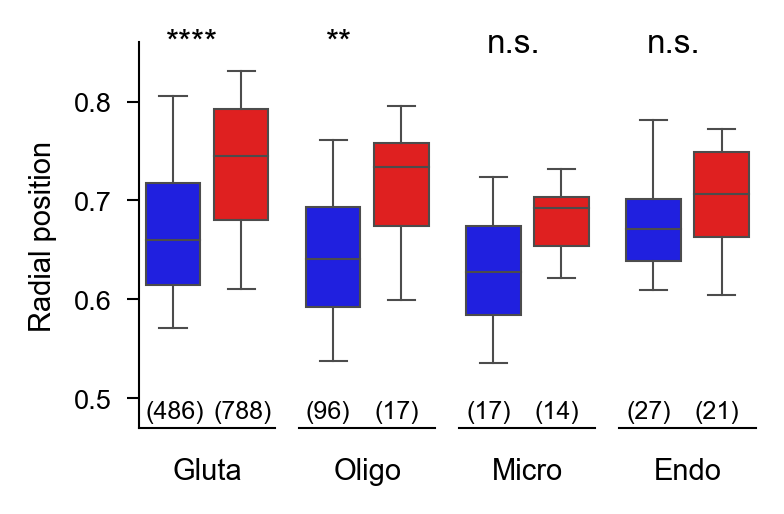

In [9]:
sel_majortypes = ['Gluta', 'Oligo', 'Micro', 'Endo']

fig = plt.figure(figsize=(2.5,1.6), dpi=300)

for i, sel_type in enumerate(sel_majortypes):
    ax = fig.add_subplot(1,4,i+1)
    
    df_plot = df_deg_with_rp[df_deg_with_rp['majortype']==sel_type].copy()
    df_plot = df_plot[df_plot['Mecp2_effect']!='NE'].copy()
    
    sns.boxplot(data=df_plot, x='Mecp2_effect', y='radial_position', order=['Down-regulated', 'Up-regulated'],
            palette={'Down-regulated':'blue','Up-regulated':'red'},ax=ax, linewidth=0.5, fliersize=0, whis=[5,95])
    
    ax.set_ylim(0.47,0.86)
    ax.set_xticks([])
    ax.set_xlabel(sel_type)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if i==0:
        ax.set_ylabel('Radial position')
        ax.set_yticks([0.5,0.6,0.7,0.8])
    else:
        ax.set_ylabel(None)
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)
    ax.text(-0.1, 0.85, plot_p(df_stat[df_stat['majortype']==sel_type]['adjusted_p'].values[0]), fontsize=8)
    
    num_up = len(df_plot[df_plot['Mecp2_effect']=='Up-regulated'])
    num_down = len(df_plot[df_plot['Mecp2_effect']=='Down-regulated'])
    
    ax.text(-0.4, 0.48, '('+str(num_down)+')', fontsize=6)
    ax.text(0.6, 0.48, '('+str(num_up)+')', fontsize=6)
    
    print([sel_type, len(df_plot[df_plot['Mecp2_effect']!='NE'])])

figure_name = os.path.join(figure_folder, 'scRNA_Mecp2_DEG_rp.pdf')
plt.savefig(figure_name)
plt.show()

In [14]:
### define function and interval for line plot
def get_upper_bound(all_values, bin_size=10):
    percentiles = np.arange(0,100, bin_size)
    percentiles = percentiles + bin_size
    upper_bound = []
    for p in percentiles:
        upper_bound.append(np.percentile(all_values, p))
    upper_bound = np.array(upper_bound)
    return upper_bound

dict_upper_bound_by_type = {}
for sel_type in majorTypes:
    dict_upper_bound_by_type[sel_type] = get_upper_bound(df_deg_with_rp[df_deg_with_rp['majortype']==sel_type]['radial_position'].values)
    
df_deg_with_rp['rp_interval'] = df_deg_with_rp.apply(lambda x: 
                                                     np.argmax(dict_upper_bound_by_type[x['majortype']]>=x['radial_position']),
                                            axis=1)

meta NOT subset; don't know how to subset; dropped


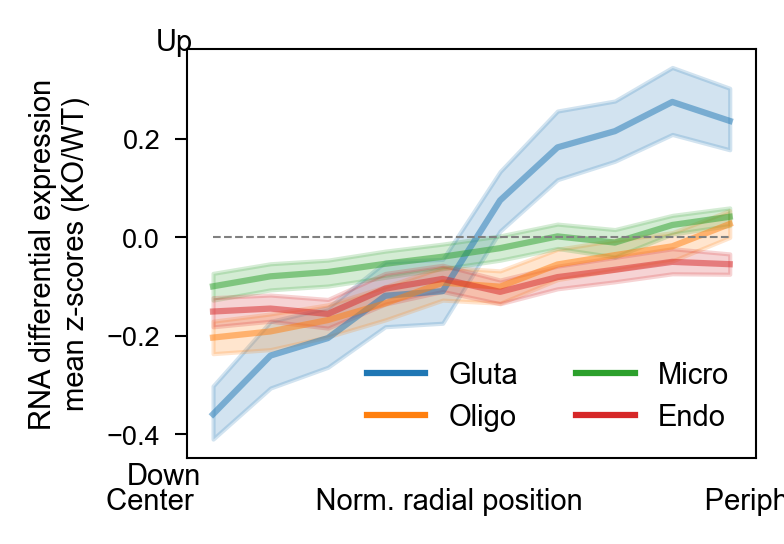

In [17]:
fig = plt.figure(figsize=(2.5,1.7), dpi=300)

ax = fig.add_subplot(111)

df_plot = df_deg_with_rp[df_deg_with_rp.majortype.isin(sel_majortypes)].copy()
#df_plot = df_plot[(df_plot['pos_cell_frac']>=0.01)].copy()

sns.lineplot(data=df_plot, x='rp_interval', y='scores', hue='majortype', ax=ax, alpha=0.5)

ax.plot([0,9], [0,0], linewidth=0.5, color='gray', linestyle='--')

ax.set_ylabel('RNA differential expression\nmean z-scores (KO/WT)')
ax.set_xlabel('Center               Norm. radial position               Peripheral')
ax.set_xticks([])

ax.text(-1.5, -0.5, 'Down', fontsize=7)
ax.text(-1, 0.38, 'Up', fontsize=7)

sns.move_legend(ax, loc='lower right', ncol=2, title=None, fontsize=7, frameon=False)

figure_name = os.path.join(figure_folder, 'scRNA_Mecp2_score_by_radial_position.pdf')
plt.savefig(figure_name)

plt.show()